# TF-IDF Implementation from Scratch and Model Training

This notebook demonstrates:
1. Manual implementation of TF-IDF (Term Frequency - Inverse Document Frequency)
2. Comparison with sklearn's TF-IDF implementation
3. Training machine learning models for text classification
4. Model evaluation with comprehensive metrics

**Dataset:** Tamil news articles with categories and processed text

## 1. Import Required Libraries

In [31]:
import pandas as pd
import numpy as np
import math
import pickle
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the Cleaned Data

In [32]:
# Load the processed data from previous notebook
df = pd.read_csv('output/processed_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (18447, 5)

Columns: ['category', 'processed_title', 'cleaned_title', 'tokenized_title', 'title']

First few rows:


,category,processed_title,cleaned_title,tokenized_title,title
0,tamilnadu,மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர் நிதின் கட்கரி கடிதம்,மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்,மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்,"மேகதாது விவகாரம்: தமிழக, கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்"
1,sports,பந்துவீச்சாளர் ஐபிஎல் விளையாடலாமா எதிரெதிர் கருத்தில் தோனி கும்பளே,பந்துவீச்சாளர்கள் ஐபிஎல் விளையாடலாமா எதிரெதிர் கருத்தில் தோனி கும்பளே,பந்துவீச்சாளர்கள் ஐபிஎல் விளையாடலாமா எதிரெதிர் கருத்தில் தோனி கும்பளே,பந்துவீச்சாளர்கள் ஐபிஎல் விளையாடலாமா? - எதிரெதிர் கருத்தில் தோனி-கும்பளே
2,tamilnadu,கனமழை எச்சரிக்கை நாளை பள்ளி கல்லூரி விடுமுறை எங்கெல்லாம் தெரியுமா,கனமழை எச்சரிக்கை நாளை பள்ளி கல்லூரிகளுக்கு விடுமுறை எங்கெல்லாம் தெரியுமா,கனமழை எச்சரிக்கை நாளை பள்ளி கல்லூரிகளுக்கு விடுமுறை எங்கெல்லாம் தெரியுமா,"கனமழை எச்சரிக்கை | நாளை பள்ளி, கல்லூரிகளுக்கு விடுமுறை.. எங்கெல்லாம் தெரியுமா?"
3,tamilnadu,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது விஜய் ஆர்பி உதயகுமார் அட்வைஸ்,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது விஜய்க்கு ஆர்பி உதயகுமார் அட்வைஸ்,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது விஜய்க்கு ஆர்பி உதயகுமார் அட்வைஸ்,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது - விஜய்க்கு ஆர்பி உதயகுமார் அட்வைஸ்
4,tamilnadu,ஆழ் காற்றழு தாழ்வுப்பகுதி எதிரொலி மாவட்டங் அலர்ட்,ஆழ்ந்த காற்றழுத்த தாழ்வுப்பகுதி எதிரொலி மாவட்டங்களுக்கு அலர்ட்,ஆழ்ந்த காற்றழுத்த தாழ்வுப்பகுதி எதிரொலி மாவட்டங்களுக்கு அலர்ட்,ஆழ்ந்த காற்றழுத்த தாழ்வுப்பகுதி எதிரொலி.. 8 மாவட்டங்களுக்கு RED அலர்ட்..


In [33]:
# Check data distribution
print("Category distribution:")
print(df['category'].value_counts())
print(f"\nTotal samples: {len(df)}")
print(f"Missing values:\n{df.isnull().sum()}")

Category distribution:
category
india                                     2191
world                                     1893
cinema                                    1811
sports                                    1748
crime                                     1627
tamilnadu                                 1589
business                                  1304
trending                                  1271
technology                                1225
features                                  1196
health                                     841
environment                                639
agriculture                                613
spiritual                                  245
lifestyle                                  103
motor                                       45
coronavirus                                 38
ampstories                                  30
women                                       20
employment-news-in-tamil-latest-update      18
Name: count, dtype: int64

T

## 3. Prepare Text Data for TF-IDF

We'll use the `cleaned_title` column which contains preprocessed Tamil text.

In [34]:
# Select the text column and target variable
documents = df['cleaned_title'].fillna('').tolist()
labels = df['category'].tolist()

print(f"Total documents: {len(documents)}")
print(f"Total labels: {len(labels)}")
print(f"\nSample document: {documents[0]}")
print(f"Sample label: {labels[0]}")

Total documents: 18447
Total labels: 18447

Sample document: மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்
Sample label: tamilnadu


## 4. TF-IDF Implementation from Scratch

### Step 1: Tokenization

Split each document into individual words (tokens).

In [35]:
def tokenize(text):
    """Tokenize text by splitting on whitespace."""
    return text.split()

tokenized_docs = [tokenize(doc) for doc in documents]
print(f"Tokenized {len(tokenized_docs)} documents")

Tokenized 18447 documents


### Step 2: Build Vocabulary

Create a vocabulary of all unique words in the corpus.

In [36]:
vocabulary = set()
for doc in tokenized_docs:
    vocabulary.update(doc)

vocabulary = sorted(list(vocabulary))
word2idx = {word: idx for idx, word in enumerate(vocabulary)}

print(f"Vocabulary size: {len(vocabulary)} unique terms")

Vocabulary size: 35612 unique terms


### Step 3: Compute Term Frequency (TF)

**Term Frequency (TF)** measures how frequently a term appears in a document.

Formula: `TF(t, d) = (Number of times term t appears in document d) / (Total number of terms in document d)`

In [37]:
def compute_tf(tokenized_doc):
    """Compute term frequency: TF(t) = count(t) / total_terms"""
    tf_dict = {}
    doc_length = len(tokenized_doc)
    term_counts = Counter(tokenized_doc)
    for term, count in term_counts.items():
        tf_dict[term] = count / doc_length
    return tf_dict

tf_docs = [compute_tf(doc) for doc in tokenized_docs]
print("Term Frequency computed")

Term Frequency computed


### Step 4: Compute Inverse Document Frequency (IDF)

**Inverse Document Frequency (IDF)** measures how important a term is across the entire corpus.

Formula: `IDF(t) = log(Total number of documents / Number of documents containing term t)`

In [39]:
def compute_idf(tokenized_docs, vocabulary):
    """Compute IDF: IDF(t) = log(N / df(t))"""
    N = len(tokenized_docs)
    idf_dict = {}
    for word in vocabulary:
        doc_count = sum(1 for doc in tokenized_docs if word in doc)
        idf_dict[word] = math.log(N / (doc_count + 1))
    return idf_dict

print("Computing IDF...")
idf_dict = compute_idf(tokenized_docs, vocabulary)
print(f"IDF computed for {len(idf_dict)} terms")

Computing IDF...
IDF computed for 35612 terms
IDF computed for 35612 terms


### Step 5: Compute TF-IDF Weights

**TF-IDF** combines both TF and IDF to get the final weight for each term in each document.

Formula: `TF-IDF(t, d) = TF(t, d) × IDF(t)`

In [40]:
def compute_tfidf(tf_dict, idf_dict):
    """Compute TF-IDF: TF-IDF(t, d) = TF(t, d) × IDF(t)"""
    tfidf_dict = {}
    for term, tf_value in tf_dict.items():
        tfidf_dict[term] = tf_value * idf_dict.get(term, 0)
    return tfidf_dict

tfidf_docs = [compute_tfidf(tf, idf_dict) for tf in tf_docs]
print("TF-IDF weights computed")

TF-IDF weights computed


### Step 6: Create TF-IDF Matrix

Convert the TF-IDF dictionaries into a matrix representation where:
- Rows represent documents
- Columns represent terms in vocabulary
- Values are TF-IDF weights

In [41]:
def create_tfidf_matrix(tfidf_docs, vocabulary, word2idx):
    """Create TF-IDF matrix: (n_documents, n_vocabulary)"""
    n_docs = len(tfidf_docs)
    n_vocab = len(vocabulary)
    tfidf_matrix = np.zeros((n_docs, n_vocab))
    
    for doc_idx, tfidf_dict in enumerate(tfidf_docs):
        for term, tfidf_value in tfidf_dict.items():
            if term in word2idx:
                term_idx = word2idx[term]
                tfidf_matrix[doc_idx, term_idx] = tfidf_value
    
    return tfidf_matrix

print("Creating TF-IDF matrix...")
tfidf_matrix_custom = create_tfidf_matrix(tfidf_docs, vocabulary, word2idx)
print(f"TF-IDF Matrix: {tfidf_matrix_custom.shape}")

Creating TF-IDF matrix...
TF-IDF Matrix: (18447, 35612)
TF-IDF Matrix: (18447, 35612)


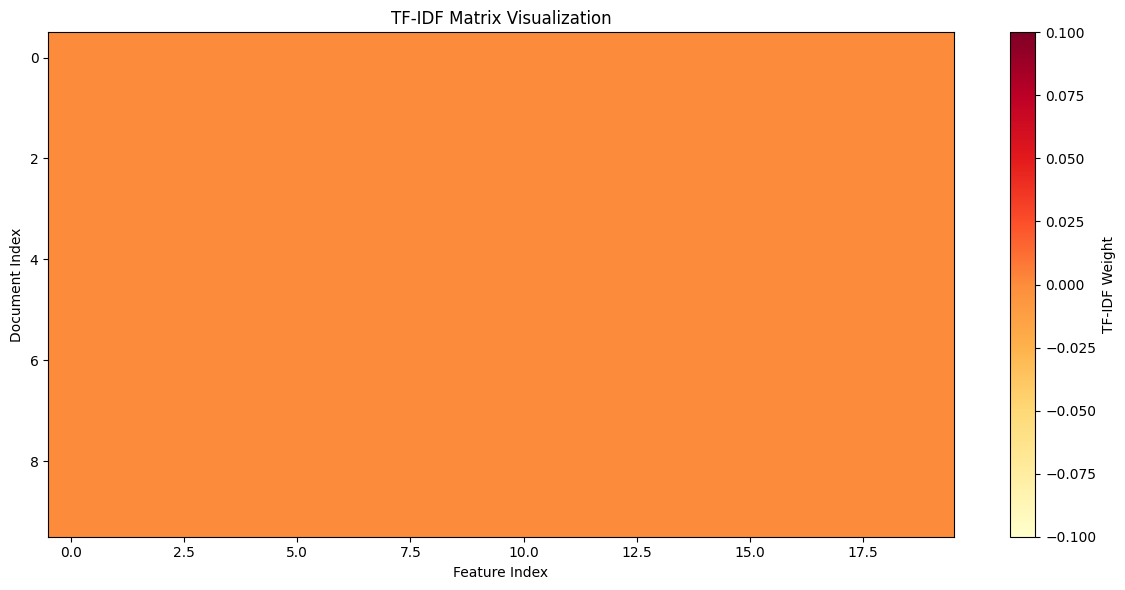

In [42]:
plt.figure(figsize=(12, 6))
plt.imshow(tfidf_matrix_custom[:10, :20], aspect='auto', cmap='YlOrRd')
plt.colorbar(label='TF-IDF Weight')
plt.xlabel('Feature Index')
plt.ylabel('Document Index')
plt.title('TF-IDF Matrix Visualization')
plt.tight_layout()
plt.show()

## 5. TF-IDF Matrix Statistics

In [44]:
# Display TF-IDF matrix statistics
print(f"TF-IDF Matrix Statistics:")
print(f"  Shape: {tfidf_matrix_custom.shape}")
print(f"  Mean: {tfidf_matrix_custom.mean():.6f}")
print(f"  Max: {tfidf_matrix_custom.max():.6f}")
print(f"  Sparsity: {(tfidf_matrix_custom == 0).sum() / tfidf_matrix_custom.size * 100:.2f}%")

TF-IDF Matrix Statistics:
  Shape: (18447, 35612)
  Mean: 0.000185
  Mean: 0.000185
  Max: 8.436363
  Max: 8.436363


MemoryError: Unable to allocate 627. MiB for an array with shape (18447, 35612) and data type bool

## 6. Prepare Data for Machine Learning

Split the data into training and testing sets.

In [45]:
# Use our custom TF-IDF matrix for modeling
X = tfidf_matrix_custom
y = np.array(labels)

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"\nTraining set label distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set label distribution:")
print(pd.Series(y_test).value_counts())

Training set size: 14757 samples
Test set size: 3690 samples
Feature dimension: 35612

Training set label distribution:
india                                     1753
world                                     1514
cinema                                    1449
sports                                    1398
crime                                     1302
tamilnadu                                 1271
business                                  1043
trending                                  1017
technology                                 980
features                                   957
health                                     673
environment                                511
agriculture                                490
spiritual                                  196
lifestyle                                   82
motor                                       36
coronavirus                                 30
ampstories                                  24
women                             

## 7. Train Machine Learning Models

Training three classification models:
1. **Naive Bayes** - Probabilistic model
2. **Linear SVM** - Support Vector Machine with linear kernel
3. **Logistic Regression** - Linear model with multinomial classification

### 7.1 Naive Bayes

In [46]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_train_pred = nb_model.predict(X_train)
nb_test_pred = nb_model.predict(X_test)
print("Naive Bayes training completed")

Naive Bayes training completed


### 7.2 Linear SVM

In [47]:
svm_model = LinearSVC(C=1.0, random_state=42, max_iter=1000)
svm_model.fit(X_train, y_train)
svm_train_pred = svm_model.predict(X_train)
svm_test_pred = svm_model.predict(X_test)
print("Linear SVM training completed")

Linear SVM training completed


### 7.3 Logistic Regression

In [48]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
print("Logistic Regression training completed")

Logistic Regression training completed


## 8. Model Evaluation

Evaluate both models using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: How many selected items are relevant
- **Recall**: How many relevant items are selected
- **F1-Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: Detailed breakdown of predictions

In [49]:
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """
    Evaluate model performance with multiple metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - {dataset_name} Set")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### 8.1 Naive Bayes Evaluation

In [50]:
nb_train_metrics = evaluate_model(y_train, nb_train_pred, "Naive Bayes", "Training")
nb_test_metrics = evaluate_model(y_test, nb_test_pred, "Naive Bayes", "Test")


Naive Bayes - Training Set
Accuracy:  0.9183 (91.83%)
Precision: 0.9225 (92.25%)
Recall:    0.9183 (91.83%)
F1-Score:  0.9154 (91.54%)

Naive Bayes - Test Set
Accuracy:  0.6415 (64.15%)
Precision: 0.6617 (66.17%)
Recall:    0.6415 (64.15%)
F1-Score:  0.6352 (63.52%)


In [51]:
print("\nClassification Report (Naive Bayes - Test Set):")
print(classification_report(y_test, nb_test_pred, zero_division=0))


Classification Report (Naive Bayes - Test Set):
                                        precision    recall  f1-score   support

                           agriculture       0.86      0.48      0.61       123
                            ampstories       0.00      0.00      0.00         6
                              business       0.65      0.63      0.64       261
                                cinema       0.77      0.80      0.78       362
                           coronavirus       0.00      0.00      0.00         8
                                 crime       0.63      0.90      0.74       325
employment-news-in-tamil-latest-update       0.00      0.00      0.00         3
                           environment       0.70      0.23      0.35       128
                              features       0.62      0.41      0.49       239
                                health       0.58      0.54      0.56       168
                                 india       0.40      0.59      0.48 

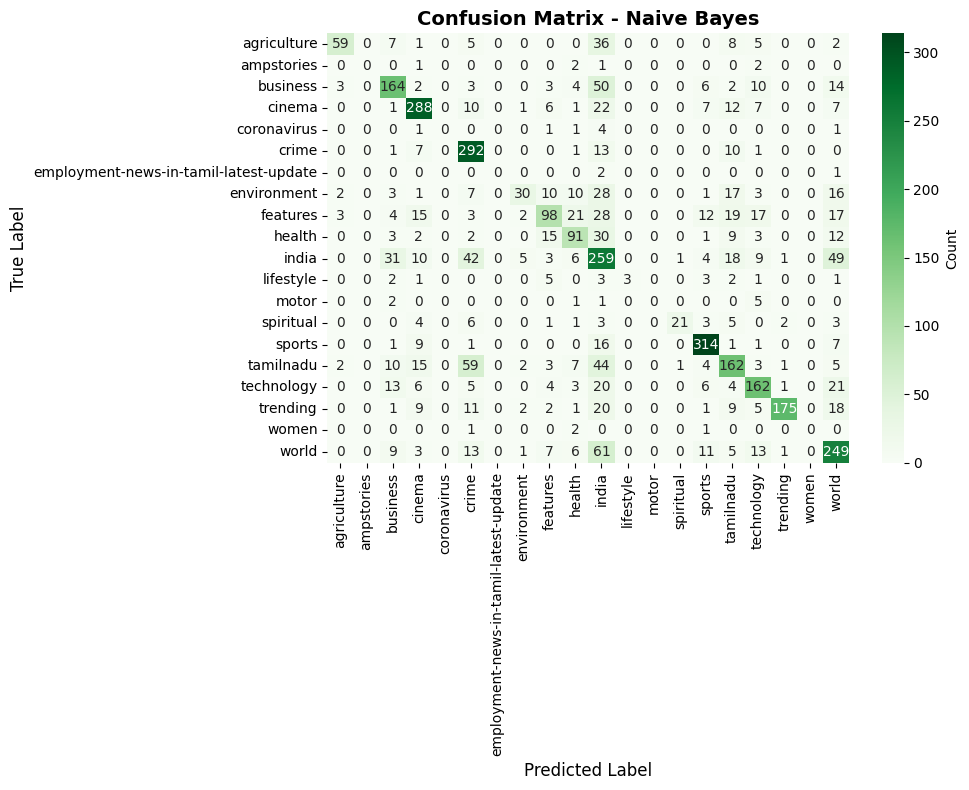

In [52]:
nb_cm = confusion_matrix(y_test, nb_test_pred)
classes = sorted(list(set(y_test)))

plt.figure(figsize=(10, 8))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Naive Bayes', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

### 8.2 Linear SVM Evaluation

In [53]:
svm_train_metrics = evaluate_model(y_train, svm_train_pred, "Linear SVM", "Training")
svm_test_metrics = evaluate_model(y_test, svm_test_pred, "Linear SVM", "Test")


Linear SVM - Training Set
Accuracy:  0.9999 (99.99%)
Precision: 0.9999 (99.99%)
Recall:    0.9999 (99.99%)
F1-Score:  0.9999 (99.99%)

Linear SVM - Test Set
Accuracy:  0.6447 (64.47%)
Precision: 0.6466 (64.66%)
Recall:    0.6447 (64.47%)
F1-Score:  0.6424 (64.24%)


In [54]:
print("\nClassification Report (Linear SVM - Test Set):")
print(classification_report(y_test, svm_test_pred, zero_division=0))


Classification Report (Linear SVM - Test Set):
                                        precision    recall  f1-score   support

                           agriculture       0.78      0.69      0.73       123
                            ampstories       0.00      0.00      0.00         6
                              business       0.61      0.61      0.61       261
                                cinema       0.75      0.79      0.77       362
                           coronavirus       0.25      0.12      0.17         8
                                 crime       0.71      0.84      0.77       325
employment-news-in-tamil-latest-update       0.00      0.00      0.00         3
                           environment       0.57      0.45      0.50       128
                              features       0.52      0.51      0.51       239
                                health       0.54      0.48      0.50       168
                                 india       0.44      0.50      0.47  

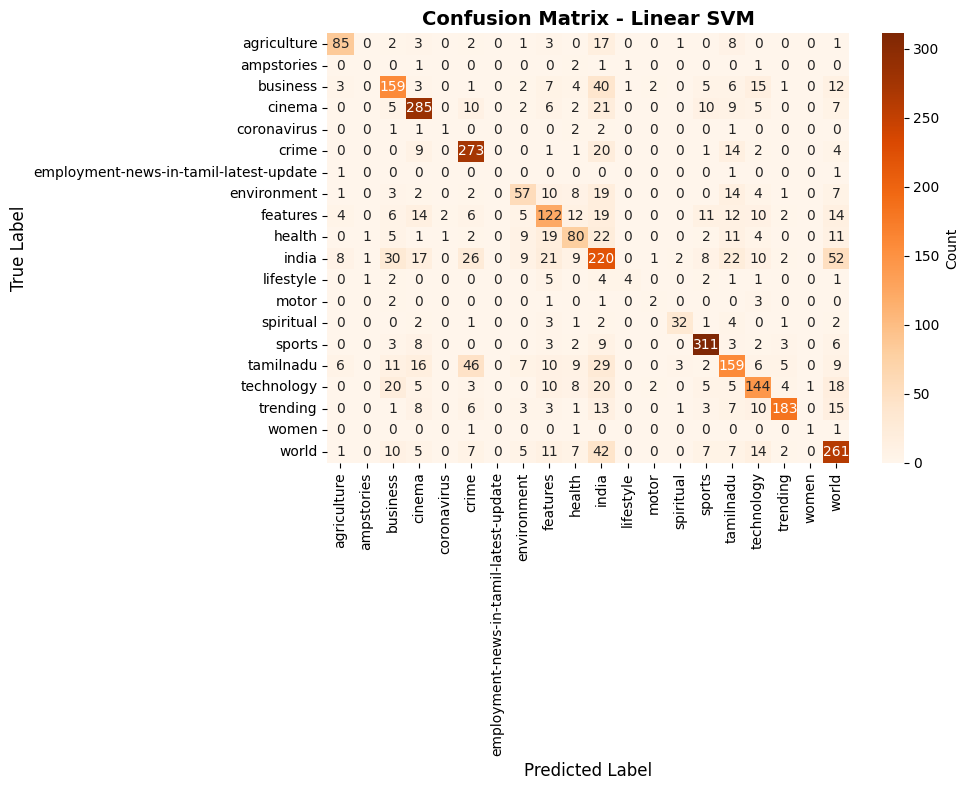

In [55]:
svm_cm = confusion_matrix(y_test, svm_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Linear SVM', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

### 8.3 Logistic Regression Evaluation

In [56]:
lr_train_metrics = evaluate_model(y_train, lr_train_pred, "Logistic Regression", "Training")
lr_test_metrics = evaluate_model(y_test, lr_test_pred, "Logistic Regression", "Test")


Logistic Regression - Training Set
Accuracy:  0.9862 (98.62%)
Precision: 0.9863 (98.63%)
Recall:    0.9862 (98.62%)
F1-Score:  0.9861 (98.61%)

Logistic Regression - Test Set
Accuracy:  0.6569 (65.69%)
Precision: 0.6724 (67.24%)
Recall:    0.6569 (65.69%)
F1-Score:  0.6562 (65.62%)


In [57]:
print("\nClassification Report (Logistic Regression - Test Set):")
print(classification_report(y_test, lr_test_pred, zero_division=0))


Classification Report (Logistic Regression - Test Set):
                                        precision    recall  f1-score   support

                           agriculture       0.83      0.61      0.70       123
                            ampstories       0.00      0.00      0.00         6
                              business       0.68      0.63      0.66       261
                                cinema       0.74      0.78      0.76       362
                           coronavirus       0.00      0.00      0.00         8
                                 crime       0.75      0.84      0.79       325
employment-news-in-tamil-latest-update       0.00      0.00      0.00         3
                           environment       0.69      0.37      0.48       128
                              features       0.52      0.51      0.52       239
                                health       0.56      0.49      0.53       168
                                 india       0.43      0.59   

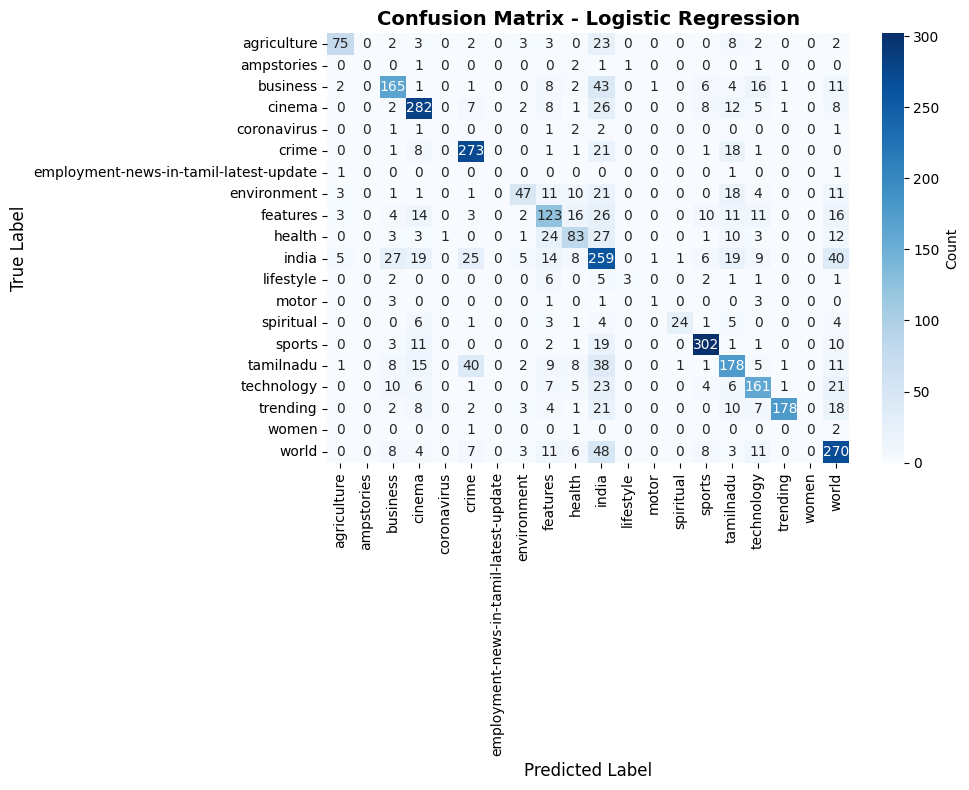

In [58]:
lr_cm = confusion_matrix(y_test, lr_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

## 9. Model Comparison

In [59]:
comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Linear SVM', 'Logistic Regression'],
    'Train Accuracy': [nb_train_metrics['accuracy'], svm_train_metrics['accuracy'], lr_train_metrics['accuracy']],
    'Test Accuracy': [nb_test_metrics['accuracy'], svm_test_metrics['accuracy'], lr_test_metrics['accuracy']],
    'Test Precision': [nb_test_metrics['precision'], svm_test_metrics['precision'], lr_test_metrics['precision']],
    'Test Recall': [nb_test_metrics['recall'], svm_test_metrics['recall'], lr_test_metrics['recall']],
    'Test F1-Score': [nb_test_metrics['f1'], svm_test_metrics['f1'], lr_test_metrics['f1']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL COMPARISON SUMMARY
              Model  Train Accuracy  Test Accuracy  Test Precision  Test Recall  Test F1-Score
        Naive Bayes        0.918276       0.641463        0.661686     0.641463       0.635245
         Linear SVM        0.999932       0.644715        0.646625     0.644715       0.642364
Logistic Regression        0.986176       0.656911        0.672447     0.656911       0.656180


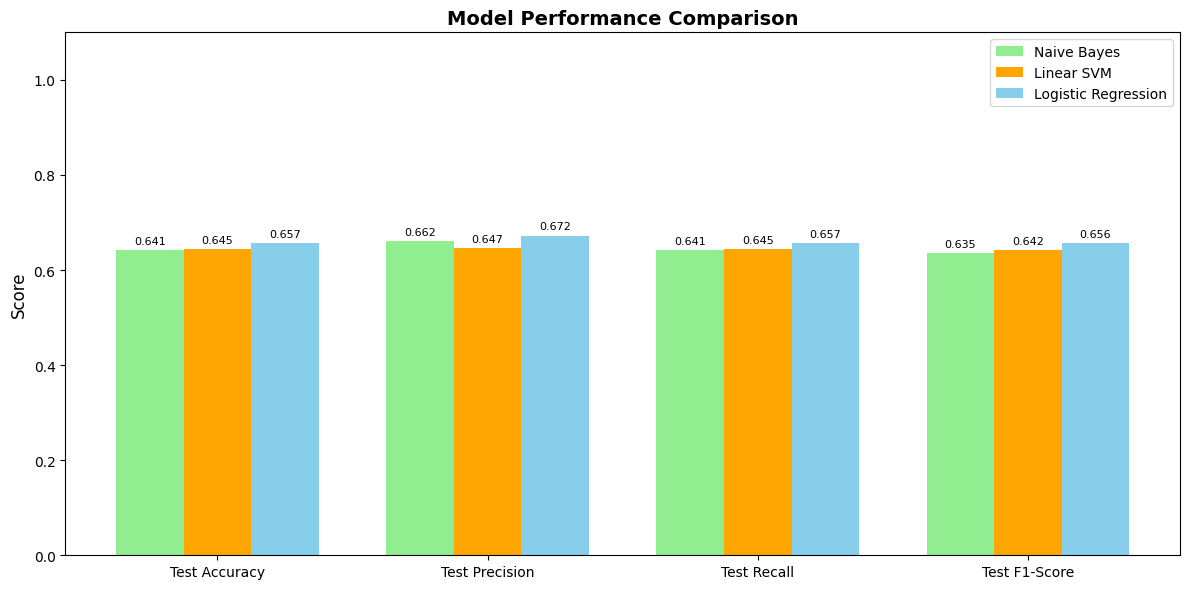

In [60]:
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, 
                [nb_test_metrics['accuracy'], nb_test_metrics['precision'], 
                 nb_test_metrics['recall'], nb_test_metrics['f1']], 
                width, label='Naive Bayes', color='lightgreen')
rects2 = ax.bar(x, 
                [svm_test_metrics['accuracy'], svm_test_metrics['precision'], 
                 svm_test_metrics['recall'], svm_test_metrics['f1']], 
                width, label='Linear SVM', color='orange')
rects3 = ax.bar(x + width, 
                [lr_test_metrics['accuracy'], lr_test_metrics['precision'], 
                 lr_test_metrics['recall'], lr_test_metrics['f1']], 
                width, label='Logistic Regression', color='skyblue')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

In [61]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"TF-IDF Implementation: {len(documents)} documents, {len(vocabulary)} terms")
print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

best_model_name = 'Naive Bayes'
best_f1 = nb_test_metrics['f1']
best_model = nb_model

if svm_test_metrics['f1'] > best_f1:
    best_model_name = 'Linear SVM'
    best_f1 = svm_test_metrics['f1']
    best_model = svm_model
    
if lr_test_metrics['f1'] > best_f1:
    best_model_name = 'Logistic Regression'
    best_f1 = lr_test_metrics['f1']
    best_model = lr_model

print(f"\nBest Model: {best_model_name} (F1: {best_f1:.4f})")
print("="*80)


SUMMARY
TF-IDF Implementation: 18447 documents, 35612 terms
Training set: 14757 samples, Test set: 3690 samples

Best Model: Logistic Regression (F1: 0.6562)


## 11. Save Models and Vectorizer

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)
os.makedirs('reports', exist_ok=True)

# Save all trained models
with open('models/category_naive_bayes.pkl', 'wb') as f:
    pickle.dump(nb_model, f)
    
with open('models/category_svm.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
    
with open('models/category_logistic.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Save the best model as the main model
with open('models/category_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save vectorizer components (vocabulary and IDF)
vectorizer_data = {
    'vocabulary': vocabulary,
    'word2idx': word2idx,
    'idf_dict': idf_dict
}
with open('models/category_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_data, f)

# Save model comparison
comparison_df.to_csv('output/model_comparison_tfidf.csv', index=False)

# Save evaluation reports
import json

reports = {
    'naive_bayes': {
        'train_metrics': nb_train_metrics,
        'test_metrics': nb_test_metrics,
        'classification_report': classification_report(y_test, nb_test_pred, output_dict=True, zero_division=0)
    },
    'svm': {
        'train_metrics': svm_train_metrics,
        'test_metrics': svm_test_metrics,
        'classification_report': classification_report(y_test, svm_test_pred, output_dict=True, zero_division=0)
    },
    'logistic': {
        'train_metrics': lr_train_metrics,
        'test_metrics': lr_test_metrics,
        'classification_report': classification_report(y_test, lr_test_pred, output_dict=True, zero_division=0)
    }
}

with open('reports/category_naive_bayes_report.json', 'w') as f:
    json.dump(reports['naive_bayes'], f, indent=2)
    
with open('reports/category_svm_report.json', 'w') as f:
    json.dump(reports['svm'], f, indent=2)
    
with open('reports/category_logistic_report.json', 'w') as f:
    json.dump(reports['logistic'], f, indent=2)

print("✓ All models saved to models/ directory")
print("✓ Vectorizer saved to models/category_vectorizer.pkl")
print("✓ Evaluation reports saved to reports/ directory")
print(f"✓ Best model ({best_model_name}) saved as models/category_model.pkl")

✓ All models saved to models/ directory
✓ Vectorizer saved to models/category_vectorizer.pkl
✓ Evaluation reports saved to reports/ directory
✓ Best model (Logistic Regression) saved as models/category_model.pkl


---

# SENTIMENT CLASSIFICATION

---

## 12. Load Sentiment Dataset

In [63]:
df_sentiment = pd.read_csv('output/processed_sentiment_data.csv')

print(f"Sentiment Dataset shape: {df_sentiment.shape}")
print(f"\nSentiment distribution:")
print(df_sentiment['sentiment'].value_counts())

sentiment_documents = df_sentiment['tokenized_title'].fillna('').tolist()
sentiment_labels = df_sentiment['sentiment'].tolist()

print(f"\nTotal sentiment documents: {len(sentiment_documents)}")
print(f"Sample: {sentiment_documents[0]}")

Sentiment Dataset shape: (4127, 7)

Sentiment distribution:
sentiment
Neutral     2307
Negative    1023
Positive     794
Unknown        3
Name: count, dtype: int64

Total sentiment documents: 4127
Sample: மோடியும் பழனிசாமியும் இருக்கும்வரை வேறு இடைத்தரகர் உருவாக முடியாது சு வெங்கடேசன் எம் பி


## 13. TF-IDF for Sentiment (Custom Implementation)

In [64]:
# Tokenize sentiment documents
sentiment_tokenized_docs = [tokenize(doc) for doc in sentiment_documents]
print(f"Tokenized {len(sentiment_tokenized_docs)} sentiment documents")

# Build vocabulary for sentiment
sentiment_vocabulary = set()
for doc in sentiment_tokenized_docs:
    sentiment_vocabulary.update(doc)
sentiment_vocabulary = sorted(list(sentiment_vocabulary))
sentiment_word2idx = {word: idx for idx, word in enumerate(sentiment_vocabulary)}
print(f"Sentiment vocabulary size: {len(sentiment_vocabulary)} unique terms")

# Compute TF for sentiment
sentiment_tf_docs = [compute_tf(doc) for doc in sentiment_tokenized_docs]
print("Sentiment TF computed")

# Compute IDF for sentiment
print("Computing sentiment IDF...")
sentiment_idf_dict = compute_idf(sentiment_tokenized_docs, sentiment_vocabulary)
print(f"Sentiment IDF computed for {len(sentiment_idf_dict)} terms")

# Compute TF-IDF for sentiment
sentiment_tfidf_docs = [compute_tfidf(tf, sentiment_idf_dict) for tf in sentiment_tf_docs]
print("Sentiment TF-IDF weights computed")

# Create TF-IDF matrix for sentiment
print("Creating sentiment TF-IDF matrix...")
sentiment_tfidf_matrix = create_tfidf_matrix(sentiment_tfidf_docs, sentiment_vocabulary, sentiment_word2idx)
print(f"Sentiment TF-IDF Matrix: {sentiment_tfidf_matrix.shape}")

Tokenized 4127 sentiment documents
Sentiment vocabulary size: 12983 unique terms
Sentiment TF computed
Computing sentiment IDF...
Sentiment IDF computed for 12983 terms
Sentiment TF-IDF weights computed
Creating sentiment TF-IDF matrix...
Sentiment TF-IDF Matrix: (4127, 12983)
Sentiment IDF computed for 12983 terms
Sentiment TF-IDF weights computed
Creating sentiment TF-IDF matrix...
Sentiment TF-IDF Matrix: (4127, 12983)


## 14. Prepare Sentiment Data for Training

In [65]:
X_sent = sentiment_tfidf_matrix
y_sent = np.array(sentiment_labels)

X_sent_train, X_sent_test, y_sent_train, y_sent_test = train_test_split(
    X_sent, y_sent, test_size=0.2, random_state=42, stratify=y_sent
)

print(f"Sentiment Training set: {X_sent_train.shape[0]} samples")
print(f"Sentiment Test set: {X_sent_test.shape[0]} samples")
print(f"Features: {X_sent_train.shape[1]}")
print(f"\nSentiment distribution (train):")
print(pd.Series(y_sent_train).value_counts())
print(f"\nSentiment distribution (test):")
print(pd.Series(y_sent_test).value_counts())

Sentiment Training set: 3301 samples
Sentiment Test set: 826 samples
Features: 12983

Sentiment distribution (train):
Neutral     1845
Negative     818
Positive     635
Unknown        3
Name: count, dtype: int64

Sentiment distribution (test):
Neutral     462
Negative    205
Positive    159
Name: count, dtype: int64


## 15. Train Sentiment Classification Models

In [66]:
# Naive Bayes for Sentiment
sent_nb_model = MultinomialNB()
sent_nb_model.fit(X_sent_train, y_sent_train)
sent_nb_train_pred = sent_nb_model.predict(X_sent_train)
sent_nb_test_pred = sent_nb_model.predict(X_sent_test)
print("Sentiment Naive Bayes completed")

# Linear SVM for Sentiment
sent_svm_model = LinearSVC(C=1.0, random_state=42, max_iter=1000)
sent_svm_model.fit(X_sent_train, y_sent_train)
sent_svm_train_pred = sent_svm_model.predict(X_sent_train)
sent_svm_test_pred = sent_svm_model.predict(X_sent_test)
print("Sentiment Linear SVM completed")

# Logistic Regression for Sentiment
sent_lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
sent_lr_model.fit(X_sent_train, y_sent_train)
sent_lr_train_pred = sent_lr_model.predict(X_sent_train)
sent_lr_test_pred = sent_lr_model.predict(X_sent_test)
print("Sentiment Logistic Regression completed")

Sentiment Naive Bayes completed
Sentiment Linear SVM completed
Sentiment Linear SVM completed
Sentiment Logistic Regression completed
Sentiment Logistic Regression completed


## 16. Evaluate Sentiment Models

In [67]:
# Evaluate Naive Bayes
sent_nb_train_metrics = evaluate_model(y_sent_train, sent_nb_train_pred, "Sentiment Naive Bayes", "Training")
sent_nb_test_metrics = evaluate_model(y_sent_test, sent_nb_test_pred, "Sentiment Naive Bayes", "Test")

# Evaluate Linear SVM
sent_svm_train_metrics = evaluate_model(y_sent_train, sent_svm_train_pred, "Sentiment Linear SVM", "Training")
sent_svm_test_metrics = evaluate_model(y_sent_test, sent_svm_test_pred, "Sentiment Linear SVM", "Test")

# Evaluate Logistic Regression
sent_lr_train_metrics = evaluate_model(y_sent_train, sent_lr_train_pred, "Sentiment Logistic Regression", "Training")
sent_lr_test_metrics = evaluate_model(y_sent_test, sent_lr_test_pred, "Sentiment Logistic Regression", "Test")


Sentiment Naive Bayes - Training Set
Accuracy:  0.9685 (96.85%)
Precision: 0.9679 (96.79%)
Recall:    0.9685 (96.85%)
F1-Score:  0.9680 (96.80%)

Sentiment Naive Bayes - Test Set
Accuracy:  0.6525 (65.25%)
Precision: 0.6495 (64.95%)
Recall:    0.6525 (65.25%)
F1-Score:  0.6507 (65.07%)

Sentiment Linear SVM - Training Set
Accuracy:  1.0000 (100.00%)
Precision: 1.0000 (100.00%)
Recall:    1.0000 (100.00%)
F1-Score:  1.0000 (100.00%)

Sentiment Linear SVM - Test Set
Accuracy:  0.6719 (67.19%)
Precision: 0.6676 (66.76%)
Recall:    0.6719 (67.19%)
F1-Score:  0.6613 (66.13%)

Sentiment Logistic Regression - Training Set
Accuracy:  0.9970 (99.70%)
Precision: 0.9970 (99.70%)
Recall:    0.9970 (99.70%)
F1-Score:  0.9969 (99.69%)

Sentiment Logistic Regression - Test Set
Accuracy:  0.6840 (68.40%)
Precision: 0.7053 (70.53%)
Recall:    0.6840 (68.40%)
F1-Score:  0.6571 (65.71%)


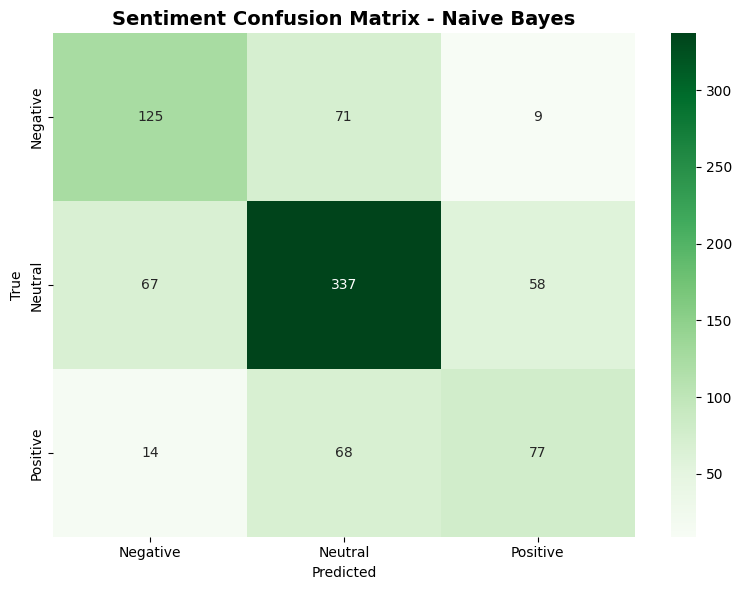

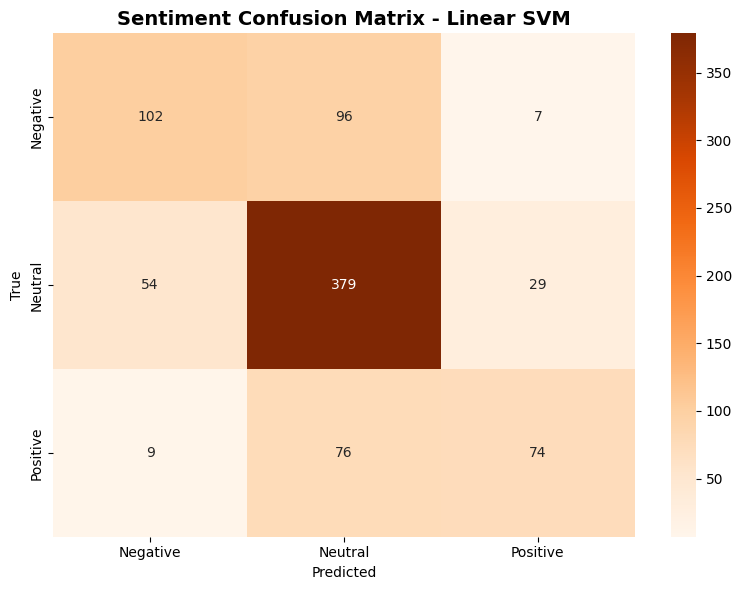

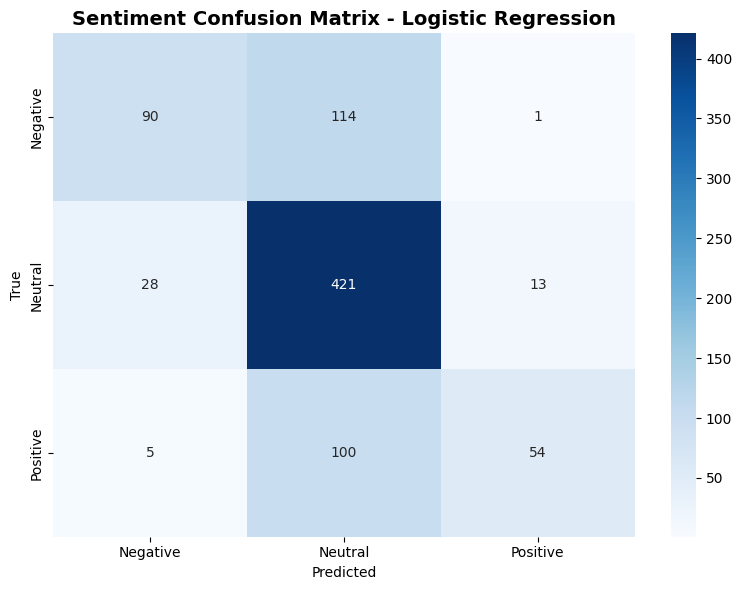

In [68]:
# Confusion matrices for sentiment models
sent_classes = sorted(list(set(y_sent_test)))

# Naive Bayes confusion matrix
sent_nb_cm = confusion_matrix(y_sent_test, sent_nb_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(sent_nb_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sent_classes, yticklabels=sent_classes)
plt.title('Sentiment Confusion Matrix - Naive Bayes', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# SVM confusion matrix
sent_svm_cm = confusion_matrix(y_sent_test, sent_svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(sent_svm_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=sent_classes, yticklabels=sent_classes)
plt.title('Sentiment Confusion Matrix - Linear SVM', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Logistic Regression confusion matrix
sent_lr_cm = confusion_matrix(y_sent_test, sent_lr_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(sent_lr_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sent_classes, yticklabels=sent_classes)
plt.title('Sentiment Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## 17. Sentiment Model Comparison

In [69]:
sent_comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Linear SVM', 'Logistic Regression'],
    'Train Accuracy': [sent_nb_train_metrics['accuracy'], sent_svm_train_metrics['accuracy'], sent_lr_train_metrics['accuracy']],
    'Test Accuracy': [sent_nb_test_metrics['accuracy'], sent_svm_test_metrics['accuracy'], sent_lr_test_metrics['accuracy']],
    'Test Precision': [sent_nb_test_metrics['precision'], sent_svm_test_metrics['precision'], sent_lr_test_metrics['precision']],
    'Test Recall': [sent_nb_test_metrics['recall'], sent_svm_test_metrics['recall'], sent_lr_test_metrics['recall']],
    'Test F1-Score': [sent_nb_test_metrics['f1'], sent_svm_test_metrics['f1'], sent_lr_test_metrics['f1']]
})

print("\n" + "="*80)
print("SENTIMENT MODEL COMPARISON")
print("="*80)
print(sent_comparison_df.to_string(index=False))
print("="*80)


SENTIMENT MODEL COMPARISON
              Model  Train Accuracy  Test Accuracy  Test Precision  Test Recall  Test F1-Score
        Naive Bayes        0.968494       0.652542        0.649518     0.652542       0.650700
         Linear SVM        1.000000       0.671913        0.667643     0.671913       0.661269
Logistic Regression        0.996971       0.684019        0.705287     0.684019       0.657088


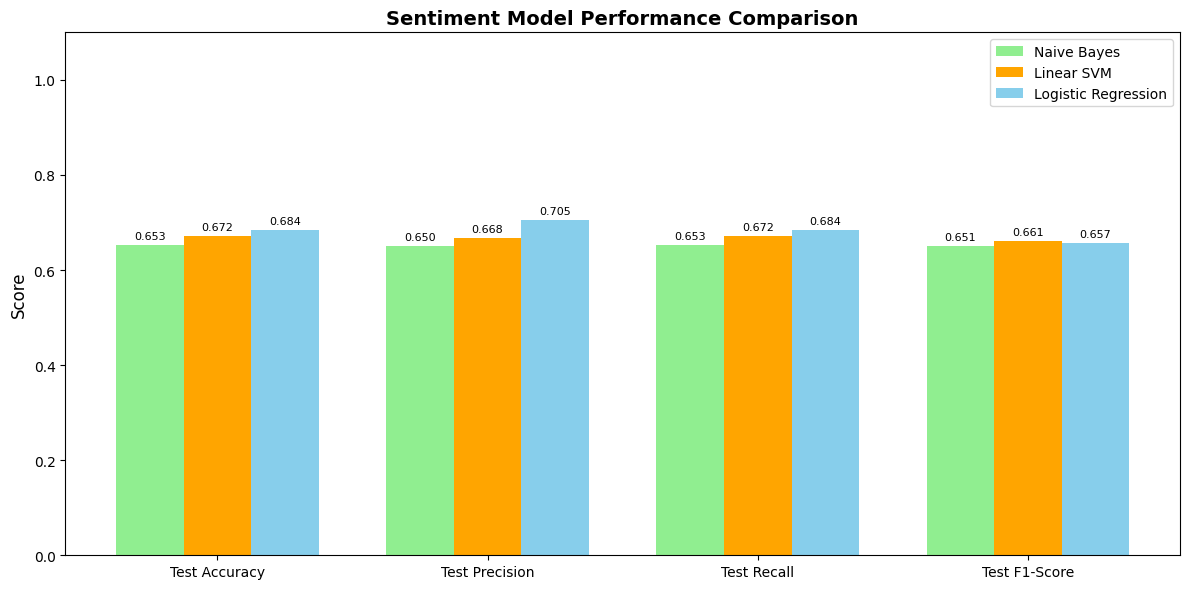

In [70]:
# Visualize sentiment model comparison
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, 
                [sent_nb_test_metrics['accuracy'], sent_nb_test_metrics['precision'], 
                 sent_nb_test_metrics['recall'], sent_nb_test_metrics['f1']], 
                width, label='Naive Bayes', color='lightgreen')
rects2 = ax.bar(x, 
                [sent_svm_test_metrics['accuracy'], sent_svm_test_metrics['precision'], 
                 sent_svm_test_metrics['recall'], sent_svm_test_metrics['f1']], 
                width, label='Linear SVM', color='orange')
rects3 = ax.bar(x + width, 
                [sent_lr_test_metrics['accuracy'], sent_lr_test_metrics['precision'], 
                 sent_lr_test_metrics['recall'], sent_lr_test_metrics['f1']], 
                width, label='Logistic Regression', color='skyblue')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Sentiment Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## 18. Save Sentiment Models and Vectorizer

In [71]:
# Determine best sentiment model
sent_best_model_name = 'Naive Bayes'
sent_best_f1 = sent_nb_test_metrics['f1']
sent_best_model = sent_nb_model

if sent_svm_test_metrics['f1'] > sent_best_f1:
    sent_best_model_name = 'Linear SVM'
    sent_best_f1 = sent_svm_test_metrics['f1']
    sent_best_model = sent_svm_model
    
if sent_lr_test_metrics['f1'] > sent_best_f1:
    sent_best_model_name = 'Logistic Regression'
    sent_best_f1 = sent_lr_test_metrics['f1']
    sent_best_model = sent_lr_model

print(f"\nBest Sentiment Model: {sent_best_model_name} (F1: {sent_best_f1:.4f})")

# Save sentiment models
with open('models/sentiment_naive_bayes.pkl', 'wb') as f:
    pickle.dump(sent_nb_model, f)
    
with open('models/sentiment_svm.pkl', 'wb') as f:
    pickle.dump(sent_svm_model, f)
    
with open('models/sentiment_logistic.pkl', 'wb') as f:
    pickle.dump(sent_lr_model, f)

# Save best sentiment model
with open('models/sentiment_model.pkl', 'wb') as f:
    pickle.dump(sent_best_model, f)

# Save sentiment vectorizer
sentiment_vectorizer_data = {
    'vocabulary': sentiment_vocabulary,
    'word2idx': sentiment_word2idx,
    'idf_dict': sentiment_idf_dict
}
with open('models/sentiment_vectorizer.pkl', 'wb') as f:
    pickle.dump(sentiment_vectorizer_data, f)

# Save sentiment comparison
sent_comparison_df.to_csv('output/sentiment_model_comparison_tfidf.csv', index=False)

# Save sentiment evaluation reports
sent_reports = {
    'naive_bayes': {
        'train_metrics': sent_nb_train_metrics,
        'test_metrics': sent_nb_test_metrics,
        'classification_report': classification_report(y_sent_test, sent_nb_test_pred, output_dict=True, zero_division=0)
    },
    'svm': {
        'train_metrics': sent_svm_train_metrics,
        'test_metrics': sent_svm_test_metrics,
        'classification_report': classification_report(y_sent_test, sent_svm_test_pred, output_dict=True, zero_division=0)
    },
    'logistic': {
        'train_metrics': sent_lr_train_metrics,
        'test_metrics': sent_lr_test_metrics,
        'classification_report': classification_report(y_sent_test, sent_lr_test_pred, output_dict=True, zero_division=0)
    }
}

with open('reports/sentiment_naive_bayes_report.json', 'w') as f:
    json.dump(sent_reports['naive_bayes'], f, indent=2)
    
with open('reports/sentiment_svm_report.json', 'w') as f:
    json.dump(sent_reports['svm'], f, indent=2)
    
with open('reports/sentiment_logistic_report.json', 'w') as f:
    json.dump(sent_reports['logistic'], f, indent=2)

print("✓ All sentiment models saved to models/ directory")
print("✓ Sentiment vectorizer saved to models/sentiment_vectorizer.pkl")
print("✓ Sentiment reports saved to reports/ directory")
print(f"✓ Best sentiment model ({sent_best_model_name}) saved as models/sentiment_model.pkl")


Best Sentiment Model: Linear SVM (F1: 0.6613)
✓ All sentiment models saved to models/ directory
✓ Sentiment vectorizer saved to models/sentiment_vectorizer.pkl
✓ Sentiment reports saved to reports/ directory
✓ Best sentiment model (Linear SVM) saved as models/sentiment_model.pkl


## 19. Final Summary

In [72]:
print("\n" + "="*80)
print("COMPLETE PIPELINE SUMMARY")
print("="*80)

print("\nCATEGORY CLASSIFICATION:")
print(f"  Dataset: {len(documents)} documents, {len(vocabulary)} terms")
print(f"  Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"  Best Model: {best_model_name} (F1: {best_f1:.4f})")
print(f"  Models saved: category_naive_bayes.pkl, category_svm.pkl, category_logistic.pkl")
print(f"  Vectorizer: category_vectorizer.pkl")

print("\nSENTIMENT CLASSIFICATION:")
print(f"  Dataset: {len(sentiment_documents)} documents, {len(sentiment_vocabulary)} terms")
print(f"  Train: {X_sent_train.shape[0]}, Test: {X_sent_test.shape[0]}")
print(f"  Best Model: {sent_best_model_name} (F1: {sent_best_f1:.4f})")
print(f"  Models saved: sentiment_naive_bayes.pkl, sentiment_svm.pkl, sentiment_logistic.pkl")
print(f"  Vectorizer: sentiment_vectorizer.pkl")

print("\nAll models trained and saved successfully!")
print("="*80)


COMPLETE PIPELINE SUMMARY

CATEGORY CLASSIFICATION:
  Dataset: 18447 documents, 35612 terms
  Train: 14757, Test: 3690
  Best Model: Logistic Regression (F1: 0.6562)
  Models saved: category_naive_bayes.pkl, category_svm.pkl, category_logistic.pkl
  Vectorizer: category_vectorizer.pkl

SENTIMENT CLASSIFICATION:
  Dataset: 4127 documents, 12983 terms
  Train: 3301, Test: 826
  Best Model: Linear SVM (F1: 0.6613)
  Models saved: sentiment_naive_bayes.pkl, sentiment_svm.pkl, sentiment_logistic.pkl
  Vectorizer: sentiment_vectorizer.pkl

All models trained and saved successfully!
